In [1]:
from pulp import LpProblem, LpVariable, LpMaximize, LpMinimize, LpStatus, lpSum, value
from pulp import PULP_CBC_CMD
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math
import seaborn as sns
import time
import os

In [2]:
# Read files
files = glob('../*/*routing_ver2/*.csv')
# print(files)
dfs, name_df = [], []
for i, file in enumerate(files):
    df_name = os.path.splitext(os.path.basename(files[i]))[0]
    name_df.append(df_name)
    df = pd.read_csv(files[i])
    dfs.append(df)
print(name_df)

['distances', 'locations', 'orders', 'small_distances', 'small_locations', 'small_orders']


In [3]:
# distances_df = dfs[0]
# locations_df = dfs[1]
# orders_df = dfs[2]
kk_df = dfs[0]
k_df = dfs[1]
r_df = dfs[2]

In [4]:
for df in [kk_df, k_df, r_df]:
    print(df.shape)
    display(df.head())

(100, 3)


,k1,k2,t
0,p,p,0.000000
1,p,s1,0.661805
2,p,s2,2.932570
3,p,s3,1.903527
4,p,s4,1.301730


(10, 4)


,k,x,y,depo_flag
0,p,0.000000,0.000000,1
1,s1,0.529473,-0.397044,0
2,s2,2.916925,-0.302511,0
3,s3,0.131532,1.898977,0
4,s4,-1.091079,-0.709964,0


(100, 5)


,r,s,w,b,e
0,r00,s4,1000,17,18
1,r01,s1,950,16,18
2,r02,s6,1330,2,4
3,r03,s5,1130,19,20
4,r04,s2,710,1,2


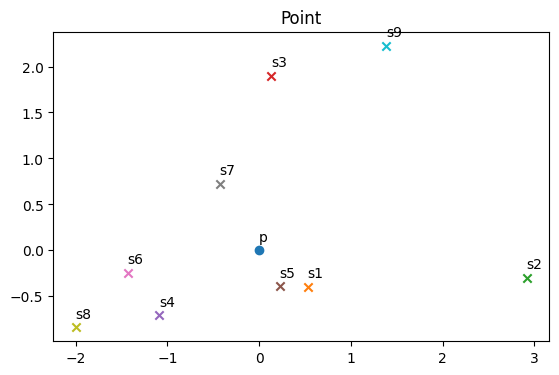

In [5]:
# display(k_df)
fig = plt.subplot()
fig.set_aspect('equal')
for row in k_df.itertuples():
    if row.depo_flag:
        fig.scatter(row.x, row.y, marker='o')
    else:
        fig.scatter(row.x, row.y, marker='x')
    fig.annotate(row.k, (row.x, row.y+0.1))
plt.title('Point')
plt.show()

In [6]:
display(kk_df.head(3))

,k1,k2,t
0,p,p,0.000000
1,p,s1,0.661805
2,p,s2,2.932570


In [7]:
display(r_df)

,r,s,w,b,e
0,r00,s4,1000,17,18
1,r01,s1,950,16,18
2,r02,s6,1330,2,4
3,r03,s5,1130,19,20
4,r04,s2,710,1,2
...,...,...,...,...,...
95,r95,s3,1290,13,14
96,r96,s5,700,4,5
97,r97,s9,1270,13,14
98,r98,s9,1100,10,12


In [8]:
# 配送日のリスト
D = list(range(r_df['b'].min(), r_df['e'].max()+1))
D
# 配送センター
P = k_df['k'][k_df['depo_flag'] == 1].to_list()[0]
P
# お店のリスト
S = k_df['k'][k_df['depo_flag'] == 0].to_list()
S
# 地点のリスト
K = [P] + S
K
# 荷物のリスト
R = r_df['r'].tolist()
R

# 変数定義用リスト
DKK = [(d, k1, k2) for d in D for k1 in K for k2 in K]
DR = [(d, r) for d in D for r in R]
DK = [(d, k) for d in D for k in K]

In [9]:
# 荷物に紐づける配送先のお店
R2S = {row.r:row.s for row in r_df.itertuples()}
# 荷物に紐づける重量
R2W = {row.r:row.w for row in r_df.itertuples()}
# 荷物に紐づける指定配送期間の開始日
R2B = {row.r:row.b for row in r_df.itertuples()}
# 荷物に紐づける指定配送期間の終了日
R2E = {row.r:row.e for row in r_df.itertuples()}
# 地点間の移動時間
KK2T = {(row.k1, row.k2):row.t for row in kk_df.itertuples()}

In [10]:
print(f' D: {D}')
print(f' P: {P}')
print(f' S: {S}')
print(f' K: {K}')
print(f' R: {R}')

 D: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
 P: p
 S: ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9']
 K: ['p', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9']
 R: ['r00', 'r01', 'r02', 'r03', 'r04', 'r05', 'r06', 'r07', 'r08', 'r09', 'r10', 'r11', 'r12', 'r13', 'r14', 'r15', 'r16', 'r17', 'r18', 'r19', 'r20', 'r21', 'r22', 'r23', 'r24', 'r25', 'r26', 'r27', 'r28', 'r29', 'r30', 'r31', 'r32', 'r33', 'r34', 'r35', 'r36', 'r37', 'r38', 'r39', 'r40', 'r41', 'r42', 'r43', 'r44', 'r45', 'r46', 'r47', 'r48', 'r49', 'r50', 'r51', 'r52', 'r53', 'r54', 'r55', 'r56', 'r57', 'r58', 'r59', 'r60', 'r61', 'r62', 'r63', 'r64', 'r65', 'r66', 'r67', 'r68', 'r69', 'r70', 'r71', 'r72', 'r73', 'r74', 'r75', 'r76', 'r77', 'r78', 'r79', 'r80', 'r81', 'r82', 'r83', 'r84', 'r85', 'r86', 'r87', 'r88', 'r89', 'r90', 'r91', 'r92', 'r93', 'r94', 'r95', 'r96', 'r97', 'r98', 'r99']


In [11]:
print(f' DKK: {DKK}')
print(f'  DR: {DR}')
print(f'  DK: {DK}')
print(f' R2S: {R2S}')
print(f' R2W: {R2W}')
print(f' R2B: {R2B}')
print(f' R2E: {R2E}')
print(f'KK2T: {KK2T}')

 DKK: [(1, 'p', 'p'), (1, 'p', 's1'), (1, 'p', 's2'), (1, 'p', 's3'), (1, 'p', 's4'), (1, 'p', 's5'), (1, 'p', 's6'), (1, 'p', 's7'), (1, 'p', 's8'), (1, 'p', 's9'), (1, 's1', 'p'), (1, 's1', 's1'), (1, 's1', 's2'), (1, 's1', 's3'), (1, 's1', 's4'), (1, 's1', 's5'), (1, 's1', 's6'), (1, 's1', 's7'), (1, 's1', 's8'), (1, 's1', 's9'), (1, 's2', 'p'), (1, 's2', 's1'), (1, 's2', 's2'), (1, 's2', 's3'), (1, 's2', 's4'), (1, 's2', 's5'), (1, 's2', 's6'), (1, 's2', 's7'), (1, 's2', 's8'), (1, 's2', 's9'), (1, 's3', 'p'), (1, 's3', 's1'), (1, 's3', 's2'), (1, 's3', 's3'), (1, 's3', 's4'), (1, 's3', 's5'), (1, 's3', 's6'), (1, 's3', 's7'), (1, 's3', 's8'), (1, 's3', 's9'), (1, 's4', 'p'), (1, 's4', 's1'), (1, 's4', 's2'), (1, 's4', 's3'), (1, 's4', 's4'), (1, 's4', 's5'), (1, 's4', 's6'), (1, 's4', 's7'), (1, 's4', 's8'), (1, 's4', 's9'), (1, 's5', 'p'), (1, 's5', 's1'), (1, 's5', 's2'), (1, 's5', 's3'), (1, 's5', 's4'), (1, 's5', 's5'), (1, 's5', 's6'), (1, 's5', 's7'), (1, 's5', 's8'), (1, 's

In [12]:
prob = LpProblem(name='vrp_small', sense=LpMinimize)

x = LpVariable.dicts('x', DKK, cat='Binary')
u = LpVariable.dicts('u', DK, cat='Interger')
y = LpVariable.dicts('y', DR, cat='Binary')
h = LpVariable.dicts('h', D, cat='Continuous', lowBound=0)

for d in D:
    for k1 in K:
        prob += lpSum([x[d, k1, k2] for k2 in K]) == lpSum([x[d, k2, k1] for k2 in K])
        prob += lpSum([x[d, k2, k1] for k2 in K]) <= 1

for d in D:
    for p in P:
        prob += u[d, p] == 0

    for s in S:
        prob += 1 <= u[d, s]
        prob += u[d, s] <= len(K) - 1

    for s1 in S:
        for s2 in S:
            prob += u[d, s1] + 1 <= u[d, s2] + (len(K) - 1) * (1 - x[d, s1, s2])

for r in R:
    prob += lpSum([y[d, r] for d in D]) <= 1

for d in D:
    for r in R:
        tar_s = R2S[r]
        prob += y[d, r] <= lpSum([x[d, k, tar_s] for k in K])

MAX_WAIGHT = 4000
for d in D:
    prob += lpSum([y[d, r] * R2W[r] for r in R]) <= MAX_WAIGHT

MAX_OFFICE_HOURS = 8
for d in D:
    prob += lpSum([KK2T[k1, k2] * x[d, k1, k2] for k1 in K for k2 in K]) - MAX_OFFICE_HOURS <= h[d]

for d in D:
    prob += h[d] <= 3

for r in R:
    for d in D:
        if d < R2B[r]:
            prob += y[d, r] == 0
        if R2E[r] < d:
            prob += y[d, r] == 0

OVERWORK_UNIT_PRICE = 3000
OUTSOURCING_WEIGHT = 46
zangyo = lpSum([OVERWORK_UNIT_PRICE * h[d] for d in D])
gaityu = lpSum(OUTSOURCING_WEIGHT * R2W[r] * (1 - lpSum([y[d, r] for d in D])) for r in R)
prob += zangyo + gaityu

In [13]:
# Solver
start = time.time()
# solver = PULP_CBC_CMD(timeLimit=60)
solver = PULP_CBC_CMD(gapRel=0.1)
end = time.time()
status = prob.solve(solver=solver)
print(f'Status : {LpStatus[status]}')
# print(f'Total Time : {end - start:.6f}')

# Result
length = 22
print(f'Overtime Cost :'.ljust(length), f'\{zangyo.value():,}')
print(f'Outsourcing Cost :'.ljust(length), f'\{gaityu.value():,}')
print(f'Total Cost: '.ljust(length), f'\{zangyo.value() + gaityu.value():,}')

Status : Optimal
Overtime Cost :        \63,572.914932
Outsourcing Cost :     \1,265,000.0
Total Cost:            \1,328,572.914932


In [19]:
for d in D:
    X = [(k1, k2) for k1 in K for k2 in K if x[d, k1, k2].value() == 1]
    time = sum([KK2T[k1, k2] for k1, k2 in X])

    print(f'---配送費: {d} 日目---')
    print(f'配送重量 : {sum([y[d, r].value() * R2W[r] for r in R])} [Kg]')
    print(f'配送時間 : {time:.2f} [h]')
    print(f'残業時間 : {h[d].value():.2f} [h]')
    print(f'x : {X}')

    tar = P
    Route = [p]
    while len(X) >= 1:
        for k1, k2 in X:
            if k1 == tar:
                tar = k2
                Route.append(k2)
                X.remove((k1, k2))

    print(f'u : {[u[d, k].value() for k in Route]}')
    print(f'配送ルート : {"->".join(Route)}')
    print()


---配送費: 1 日目---
配送重量 : 3540.0 [Kg]
配送時間 : 9.33 [h]
残業時間 : 1.33 [h]
x : [('p', 's2'), ('s2', 's9'), ('s3', 's7'), ('s7', 'p'), ('s9', 's3')]
u : [0.0, 1.0, 2.0, 8.0, 9.0, 0.0]
配送ルート : p->s2->s9->s3->s7->p

---配送費: 2 日目---
配送重量 : 3710.0 [Kg]
配送時間 : 7.60 [h]
残業時間 : 0.00 [h]
x : [('p', 's7'), ('s3', 'p'), ('s4', 's3'), ('s6', 's4'), ('s7', 's6')]
u : [0.0, 1.0, 2.0, 8.0, 9.0, 0.0]
配送ルート : p->s7->s6->s4->s3->p

---配送費: 3 日目---
配送重量 : 3580.0 [Kg]
配送時間 : 10.03 [h]
残業時間 : 2.03 [h]
x : [('p', 's9'), ('s4', 's6'), ('s6', 's8'), ('s8', 'p'), ('s9', 's4')]
u : [0.0, 1.0, 2.0, 8.0, 9.0, 0.0]
配送ルート : p->s9->s4->s6->s8->p

---配送費: 4 日目---
配送重量 : 3920.0 [Kg]
配送時間 : 6.19 [h]
残業時間 : 0.00 [h]
x : [('p', 's4'), ('s4', 's8'), ('s5', 'p'), ('s6', 's7'), ('s7', 's5'), ('s8', 's6')]
u : [0.0, 1.0, 2.0, 3.0, 8.0, 9.0, 0.0]
配送ルート : p->s4->s8->s6->s7->s5->p

---配送費: 5 日目---
配送重量 : 3770.0 [Kg]
配送時間 : 8.02 [h]
残業時間 : 0.02 [h]
x : [('p', 's6'), ('s3', 's9'), ('s6', 's3'), ('s9', 'p')]
u : [0.0, 1.0, 2.0, 9.0, 0.0]


In [15]:
len(x), len(u), len(y), len(h)

(2000, 200, 2000, 20)

In [20]:
for r in R:
    owned_flag = sum([y[d, r].value() for d in D])
    if owned_flag:
        tar_d = [d for d in D if y[d, r].value() == 1][0]
        text = f'荷物{r} (お店{R2S[r]}, {R2W[r]}[kg]) - 配送日: {tar_d}日目'
    else:
        gaityu = OUTSOURCING_WEIGHT * R2W[r]
        text = f'荷物{r} (お店{R2S[r]}, {R2W[r]}[kg]) - 外注費用: {gaityu}円'
    if tar_d == 1:
        print(text)

荷物r04 (お店s2, 710[kg]) - 配送日: 1日目
荷物r46 (お店s9, 1060[kg]) - 配送日: 1日目
荷物r53 (お店s9, 890[kg]) - 配送日: 1日目
荷物r77 (お店s3, 880[kg]) - 配送日: 1日目


In [24]:
resD2S = {d:set() for d in D}
for d, r in y:
    if y[d, r].value() == 1:
        resD2S[d].add(R2S[r])

for d in D:
    print(f'---配送日: {d}日目---')
    X = [(k1, k2) for k1 in K for k2 in K if x[d, k1, k2].value() == 1]
    time = sum(KK2T[k1, k2] for k1, k2 in X)
    print(f'移動時間: {time:.02f}[h]')

    routeS = set([k1 for k1, k2 in X]) - set([p])
    print(f'(A)配送ルートのお店: {routeS}')

    targetS = resD2S[d]
    print(f'(B)荷物の注文があるお店: {targetS}')

    print(f'(A) - (B): {routeS - targetS}')

---配送日: 1日目---
移動時間: 9.33[h]
(A)配送ルートのお店: {'s7', 's3', 's2', 's9'}
(B)荷物の注文があるお店: {'s9', 's3', 's2'}
(A) - (B): {'s7'}
---配送日: 2日目---
移動時間: 7.60[h]
(A)配送ルートのお店: {'s7', 's3', 's6', 's4'}
(B)荷物の注文があるお店: {'s7', 's3', 's6', 's4'}
(A) - (B): set()
---配送日: 3日目---
移動時間: 10.03[h]
(A)配送ルートのお店: {'s8', 's6', 's4', 's9'}
(B)荷物の注文があるお店: {'s8', 's6', 's9'}
(A) - (B): {'s4'}
---配送日: 4日目---
移動時間: 6.19[h]
(A)配送ルートのお店: {'s6', 's4', 's7', 's5', 's8'}
(B)荷物の注文があるお店: {'s8', 's6', 's4'}
(A) - (B): {'s5', 's7'}
---配送日: 5日目---
移動時間: 8.02[h]
(A)配送ルートのお店: {'s3', 's6', 's9'}
(B)荷物の注文があるお店: {'s3', 's6', 's9'}
(A) - (B): set()
---配送日: 6日目---
移動時間: 4.23[h]
(A)配送ルートのお店: {'s5', 's7', 's4'}
(B)荷物の注文があるお店: {'s5', 's4'}
(A) - (B): {'s7'}
---配送日: 7日目---
移動時間: 6.75[h]
(A)配送ルートのお店: {'s6', 's7', 's5', 's8', 's1'}
(B)荷物の注文があるお店: {'s7', 's8', 's1'}
(A) - (B): {'s5', 's6'}
---配送日: 8日目---
移動時間: 10.07[h]
(A)配送ルートのお店: {'s7', 's2', 's5', 's3', 's1'}
(B)荷物の注文があるお店: {'s2', 's3', 's1'}
(A) - (B): {'s5', 's7'}
---配送日: 9日目---
移動時間: 10.

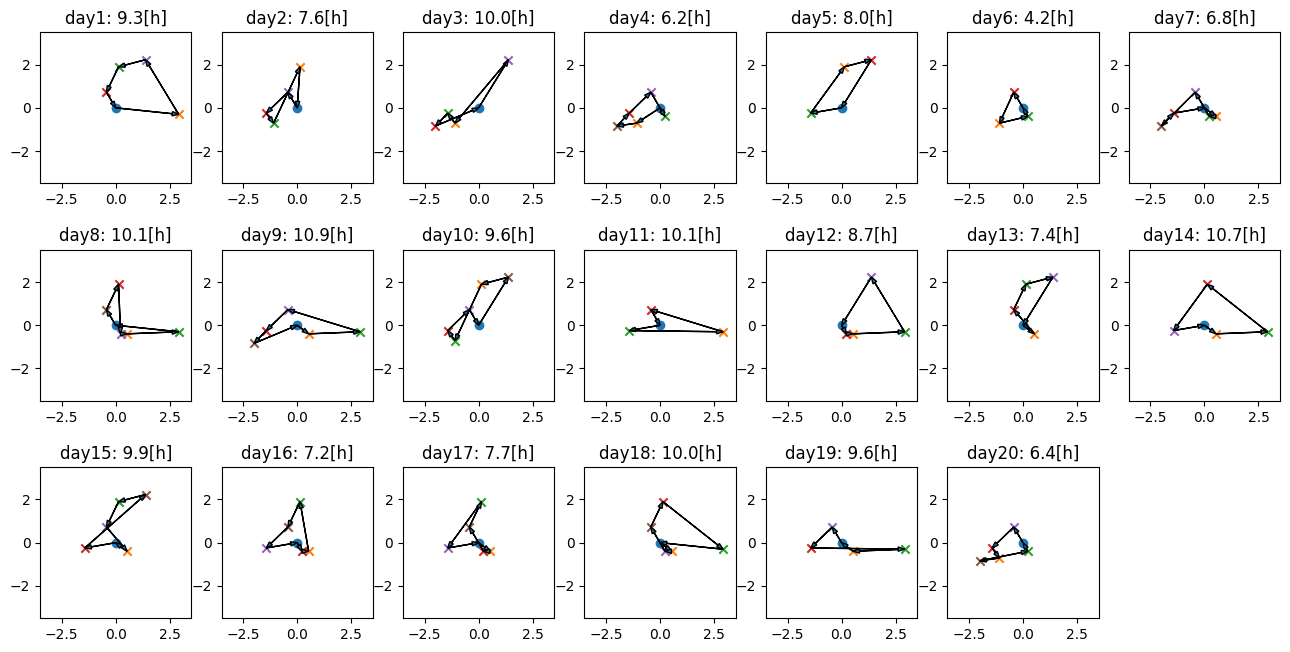

In [40]:
K2XY = {row.k: (row.x, row.y) for row in k_df.itertuples()}

fig = plt.figure(figsize=(16, 8))
for i in range(len(D)):
    d = D[i]
    X = [(k1, k2) for k1 in K for k2 in K if x[d, k1, k2].value() == 1]
    routeK = [k1 for k1, k2 in X]
    time = sum([KK2T[k1, k2] for k1, k2 in X])

    title_text = f'day{d}: {time:.01f}[h]'
    ax = fig.add_subplot(3, 7, i+1, title=title_text, xlim=(-3.5, 3.5), ylim=(-3.5, 3.5))
    ax.set_aspect('equal')

    for row in k_df.itertuples():
        if row.k in routeK:
            if row.depo_flag:
                ax.scatter(row.x, row.y, marker='o')
            else:
                ax.scatter(row.x, row.y, marker='x')
    
    for k1, k2 in X:
        (x1, y1) = K2XY[k1]
        (x2, y2) = K2XY[k2]
        ax.arrow(x1, y1, (x2-x1), (y2-y1), head_width=0.2, length_includes_head=True)

    